In [52]:
#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

#advectionGP
from advectionGP.models import AdjointSecondOrderODEModel as ODEModel #Model module builds basic parts of the ODE problem, combines other classes into full model
 
from advectionGP.models import AdjointAdvectionDiffusionModel as PDEModel

from advectionGP.wind import WindSimple#Wind model

from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model


#Plotting tools
import matplotlib.pyplot as plt

def plotresult(mod,mZ=None,cZ=None,knownS=None,newS=None,figfilename='fig.pdf'):
    if mZ is None:
        mZ,cZ = mod.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
    sourceInf = mod.computeSourceFromPhi(mZ) # Generates estimated source using mean of the inferred distribution
    concInf=mod.computeConcentration(sourceInf) # Generates estimated concentration from inferred source

    """params: mean and covar of Z"""
    source_samples = []
    conc_samples=[]    
    for z_samp in np.random.multivariate_normal(mZ, cZ,200):
        source_samples.append(mod.computeSourceFromPhi(z_samp))
        conc_samples.append(mod.computeConcentration(mod.computeSourceFromPhi(z_samp)))
    source_samples=np.array(source_samples)
    conc_samples=np.array(conc_samples)
    

    source_lower_ci = np.percentile(source_samples,2.5,0)
    source_upper_ci = np.percentile(source_samples,97.5,0)
    source_mean = np.percentile(source_samples,50,0)

    conc_lower_ci = np.percentile(conc_samples,2.5,0)
    conc_upper_ci = np.percentile(conc_samples,97.5,0)
    conc_mean = np.percentile(conc_samples,50,0)

    xtest=np.arange(Nt)

    plt.figure(figsize=(10, 10))
    plt.subplot(2,1,1)
    plt.plot(xtest,sourceInf,'b-',label="Estimated source term")
    plt.plot(xtest,sourceGT,'r--',label="True source term")

    #plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
    #plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
    plt.fill_between(xtest,source_lower_ci,source_upper_ci,alpha=0.5)
    if knownS is not None:
        plt.plot(knownS,newS,'-r',lw=3,label='Fixed')
        
    plt.legend()
    plt.title("Source function ")
    plt.xlabel("Input, t")
    plt.ylabel("output, f(t)")
    #plt.ylim([-5,5])
    
    
    plt.subplot(2,1,2)
    #plt.figure(figsize=(15, 10))

    plt.plot(xtest,concInf,'b-',label='Estimated concentration')
    plt.plot(xtest,concTrain,'r--',label='True concentration')

    #plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
    #plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
    plt.fill_between(xtest,conc_lower_ci,conc_upper_ci,alpha=0.5)
    plt.legend()
    plt.title("Concentration")
    plt.xlabel("Input, t")
    plt.ylabel("output, f(t)")
    #plt.ylim([-5,5])
    plt.savefig(figfilename)
    plt.show()
    
def getnewdist(m,c,knownS,newS,model):
    """
    Pass:
     m = mean of Z
     c = covariance of Z
     knownS = a binary vector saying which sources we know
     newS = their values
     model = the model we need to use.
    """
    Phi = []
    for i,phi in enumerate(model.kernel.getPhi1D(model.coords)):
        Phi.append(phi[:,0])
    Phi = np.array(Phi).T
    
    inv = np.linalg.inv(Phi[knownS,:] @ c @ Phi[knownS,:].T + 0.1*np.eye(len(knownS)))
    newmean = m - (Phi[knownS,:] @ c).T @ inv @ (Phi[knownS,:] @ m - newS)
    newcov = c - (Phi[knownS,:] @ c).T @ inv @ (Phi[knownS,:] @ c)
    return newmean, newcov


# ODE Example

In [53]:
avg=0.01 # time that an observation is taken for
tlocL = np.linspace(0,9.9,20) # observation start times
X= np.zeros((len(tlocL),2)) # initiate X
# Build sensor locations
X[:,0] = tlocL #lower time
X[:,1] = X[:,0]+avg # upper time

sensors = FixedSensorModel(X,0) # establish sensor model arguments are sensor locations and spatial averaging (not applicable in 1D case so set to 0)

### Generate forward model with parameter set p1=[0.8,5,-1]

In [3]:
k_0 = -1 #Diffusion coefficient
u=0.8
eta=5

p1 = [u,eta,k_0]

noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0],[10])# edges of the grid - in units of time
kForward = EQ(0.6, 4.0) # generate EQ kernel arguments are lengthscale and variance
res = [500] # grid size for time

In [54]:
m = ODEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kForward,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #initiate PDE model to build concentration

dt,dt2,Nt = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
#scale = 1-np.exp(-(np.arange(500)-200)**2/3000)
scale = (1/(1+np.exp(np.arange(-100,400)/10))+1/(1+np.exp(np.arange(350,-150,-1)/10)))
sourceGT=m.computeSourceFromPhi(z)# Compute ground truth source by approximating GP
sourceGT*=scale
sourceGT+=5
#sourceGT = np.ones(m.resolution)  # Example constant source
concTrain=m.computeConcentration(sourceGT) # Compute concentration - runs ODE forward model
yTrain= m.computeObservations(addNoise='TRUE') # Compute observations with noise uses m.sensormodel for observation locations

### Infer Source with parameter set p1

In [55]:
#%%timeit
N_feat =100 #Number of features used to infer the source
kInverse = EQ(0.6, 4) # Initiate kernel for inverse problem
mInfer = ODEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,k_0=p1[2],u=p1[0],eta=p1[1]) #Initiate new model for inference
mInfer.computeModelRegressors(); # Compute regressor matrix 
#meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
#sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
#concInfer=mInfer.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source


Getting Grid Step Size
Building X matrix
Calculating Adjoints...
19/20 
Calculating Phis...
99/100 


Calculating SS
Inverting SS
Computing meanZ
Done


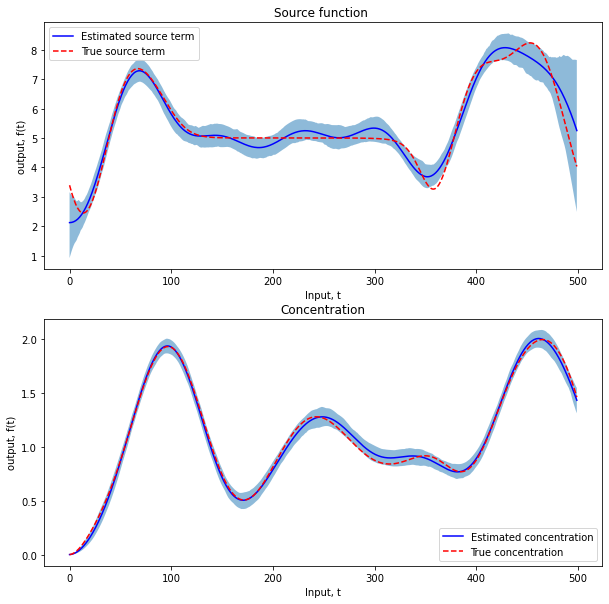

In [56]:
plotresult(mInfer,figfilename = 'correctpnofix.pdf')

# Fix s

In [57]:
knownS = list(range(150,300))
newS = np.zeros(150)

meanZ,covZ = mInfer.computeZDistribution(yTrain)
newmeanZ, newcovZ = getnewdist(meanZ, covZ,knownS,newS,mInfer)

Calculating SS
Inverting SS
Computing meanZ
Done


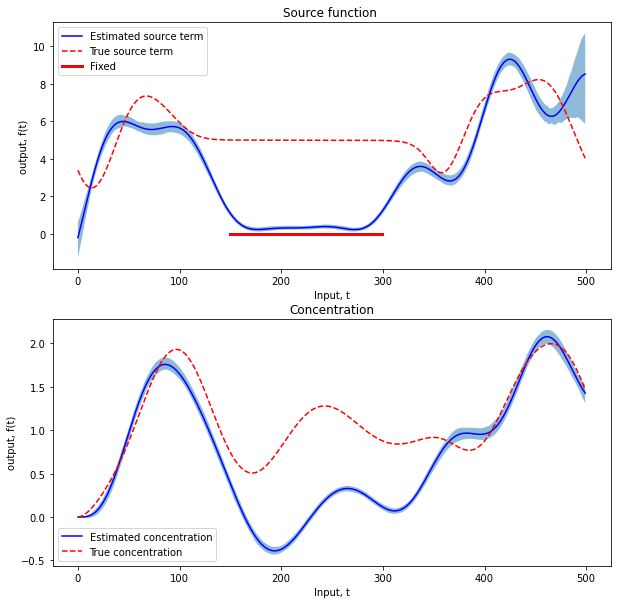

In [58]:
plotresult(mInfer,newmeanZ,newcovZ,knownS=knownS,newS=newS, figfilename = 'correctpfix.pdf')

### Infer source with parameter set p2=[3,1,-0.05]

In [59]:
#%%timeit
p2 = [3, 1,-0.05]
N_feat =100 #Number of features used to infer the source

mInfer.k_0=p2[2]
mInfer.u=p2[0]
mInfer.eta=p2[1]

mInfer.computeModelRegressors(); # Compute regressor matrix 
#meanZ2, covZ2 = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix


Getting Grid Step Size
Building X matrix
Calculating Adjoints...
19/20 
Calculating Phis...
99/100 


Calculating SS
Inverting SS
Computing meanZ
Done


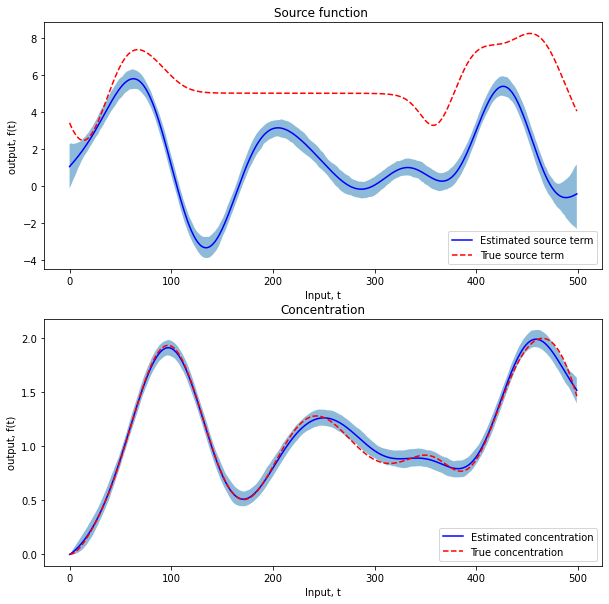

In [60]:
plotresult(mInfer, figfilename = 'wrongpnofix.pdf')

# Conditioning on a source...

In [ ]:
s = np.array([1,0,0])
s = np.array([0,1,0])
s = np.array([0,0,1])

In [ ]:
Phi z = 0

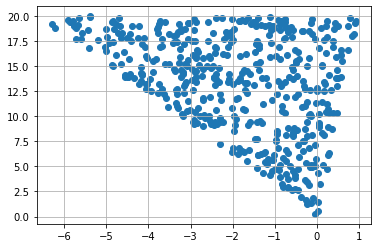

In [102]:
Phi = np.array([[-2,0.1],[1,0.5],[3,1]])

z = (np.random.rand(10000,2)*40-20).T
keep = np.all((Phi @ z)>0,0)
plt.scatter(z[0,keep],z[1,keep])
plt.grid()

In [81]:
Phi.shape

(3, 2)

(3, 1)

In [74]:
s = np.array([[1,0,0]])
import numpy as np
#np.linalg.solve(Phi,s)
#s = Phi @ z

In [61]:
#news0 = np.array([0])
#newmeanZ2 = meanZ2 - (Phi[0:1,:] @ covZ2).T @ np.linalg.inv(Phi[0:1,:] @ covZ2 @ Phi[0:1,:].T) @ (news0 - Phi[0:1,:] @ meanZ2)
#newcovZ2 = covZ2 - (Phi[0:1,:] @ covZ2).T @ np.linalg.inv(Phi[0:1,:] @ covZ2 @ Phi[0:1,:].T) @ (Phi[0:1,:] @ covZ2)

In [62]:
meanZ,covZ = mInfer.computeZDistribution(yTrain)
sourceInf = mInfer.computeSourceFromPhi(meanZ)

Calculating SS
Inverting SS
Computing meanZ
Done


In [63]:
negpoints = np.where(sourceInf<0)[0]
newmeanZ, newcovZ = getnewdist(meanZ, covZ,negpoints,np.zeros(len(negpoints)),mInfer)

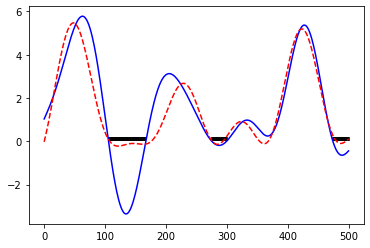

In [64]:
sourceInf = mInfer.computeSourceFromPhi(meanZ)
plt.plot(sourceInf,'b-')
plt.vlines(negpoints,0,0.2)
newsourceInf = mInfer.computeSourceFromPhi(newmeanZ)
plt.plot(newsourceInf,'--r')

In [70]:
knownS = list(range(150,300))
newS = np.zeros(150)

meanZ,covZ = mInfer.computeZDistribution(yTrain)
newmeanZ, newcovZ = getnewdist(meanZ, covZ,knownS,newS,mInfer)

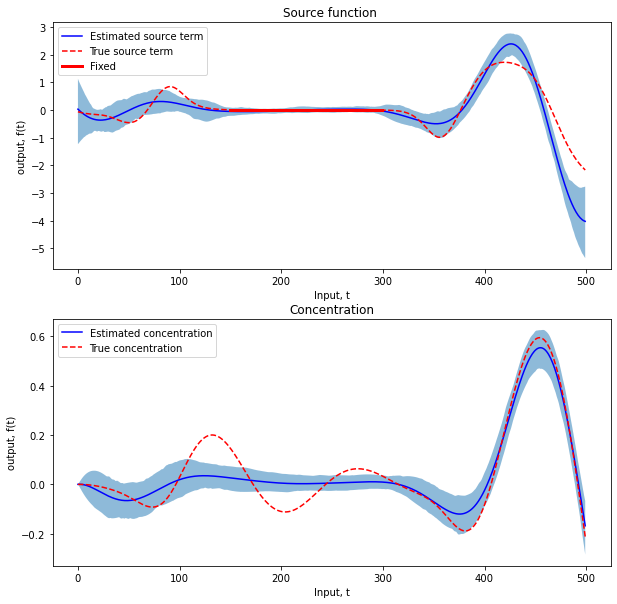

In [71]:
plotresult(mInfer,newmeanZ,newcovZ,knownS=knownS,newS=newS,figfilename = 'wrongpfix.pdf')

# PDE Example

In [9]:
# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(1,8,3) # lower time
xloc=np.linspace(2,8,4) # x locations
yloc=np.linspace(2,8,4) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1] # x location
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2] # ylocation
X[:,1] = X[:,0]+1 # upper time

sensors = FixedSensorModel(X,1) # establish sensor model arguments are sensor locations and spatial averaging

In [63]:
k_0 = 0.01 #Diffusion
R=0.1
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0,0,0],[10,10,10])# corners of the grid - in units of space
k = EQ(2, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [50,50,50] # grid size for time, x and y



windmodel=WindSimple(0.1,0.1) # establish fixed wind model
m = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #initiate PDE model to build concentration

dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
sourceGT=(m.computeSourceFromPhi(z))# Compute source

In [64]:
concTrain=m.computeConcentration(sourceGT) # Compute concentration - runs advection diffusion forward model
yTrain= m.computeObservations() # Compute observations with noise uses m.sensormodel for observation locations

## Infer source with parameters p1=[(0.001,0.001),0.001]

In [65]:
N_feat =500 #Number of features used to infer the source
k1 = EQ(2, 2.0) 
k2 = EQ(2, 2.0) 

mPDE = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k1,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #Initiate new model for inference
regressPDE = mPDE.computeModelRegressors() # Compute regressor matrix
meanZPDE, covZPDE = mPDE.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourcePDE = mPDE.computeSourceFromPhi(meanZPDE) # Generates estimated source using inferred distributio
concPDE = mPDE.computeConcentration(sourcePDE)
yOut = mPDE.computeObservations()

Calculating Adjoints...
47/48 
Calculating Phis...
499/500 


### MSE between ground truth source and inferred source

In [66]:
np.mean((sourceGT-sourcePDE)**2)

0.7601675394386913

### MSE between ground truth source and inferred source

In [67]:
np.mean((concTrain-concPDE)**2)

2.873136730034791

### MSE between observations and inferred observations

In [68]:
np.mean((yTrain-yOut)**2)

0.0006643702784585467

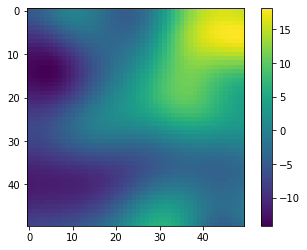

In [69]:
plt.imshow(concTrain[30])
plt.colorbar()

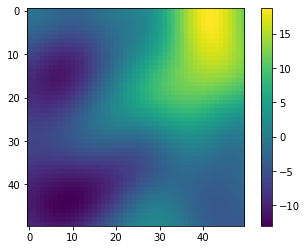

In [70]:
plt.imshow(concPDE[30])
plt.colorbar()

## Infer source with parameters p2 = [(0.000001,0.000001),0.0000001]

In [89]:
N_feat =500 #Number of features used to infer the source
k1 = EQ(2, 2.0) 
k2 = EQ(2, 2.0) 

k_0=0.0000001
u=[]

windmodel2=WindSimple(0.000001,0.0000001) # establish fixed wind model

mPDE.windmodel=windmodel2
mPDE.u = mPDE.windmodel.getu(mPDE)
mPDE.k_0=k_0

regressPDE2 = mPDE.computeModelRegressors() # Compute regressor matrix
meanZPDE2, covZPDE2 = mPDE.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourcePDE2 = mPDE.computeSourceFromPhi(meanZPDE2) # Generates estimated source using inferred distributio
concPDE2 = mPDE.computeConcentration(sourcePDE2)
yOut2 = mPDE.computeObservations()

Calculating Adjoints...
47/48 
Calculating Phis...
499/500 


### MSE between ground truth source and inferred source

In [90]:
np.mean((sourceGT-sourcePDE2)**2)

0.8602494626175804

### MSE between ground truth conc and inferred conc

In [91]:
np.mean((concTrain-concPDE2)**2)

3.8323241333731013

### MSE between observations and inferred observations

In [92]:
np.mean((yTrain-yOut2)**2)

5.717290296231882e-05

Note that source estimation and concentration estimation remain of similary quality despite different parameters.

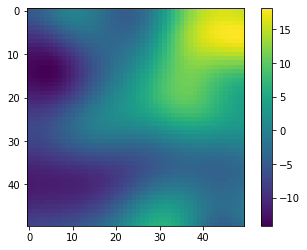

In [93]:
plt.imshow(concTrain[30])
plt.colorbar()

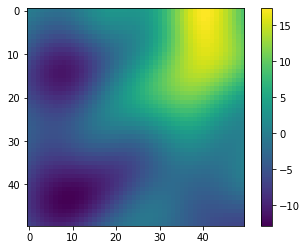

In [94]:
plt.imshow(concPDE2[30])
plt.colorbar()